## Exploratory data analysis

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import math

import gc

color = sns.color_palette()

We first load the data.

In [2]:
aisles = pd.read_csv('aisles.csv/aisles.csv')
departments = pd.read_csv('departments.csv/departments.csv')
order_prod_prior = pd.read_csv('order_products__prior.csv/order_products__prior.csv')
order_prod_train = pd.read_csv('order_products__train.csv/order_products__train.csv')
orders = pd.read_csv('orders.csv/orders.csv')
products = pd.read_csv('products.csv/products.csv')

Let us look at the data.

In [3]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [4]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [5]:
order_prod_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [6]:
order_prod_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [7]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [8]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


### Order size

We study the distribution of order size.

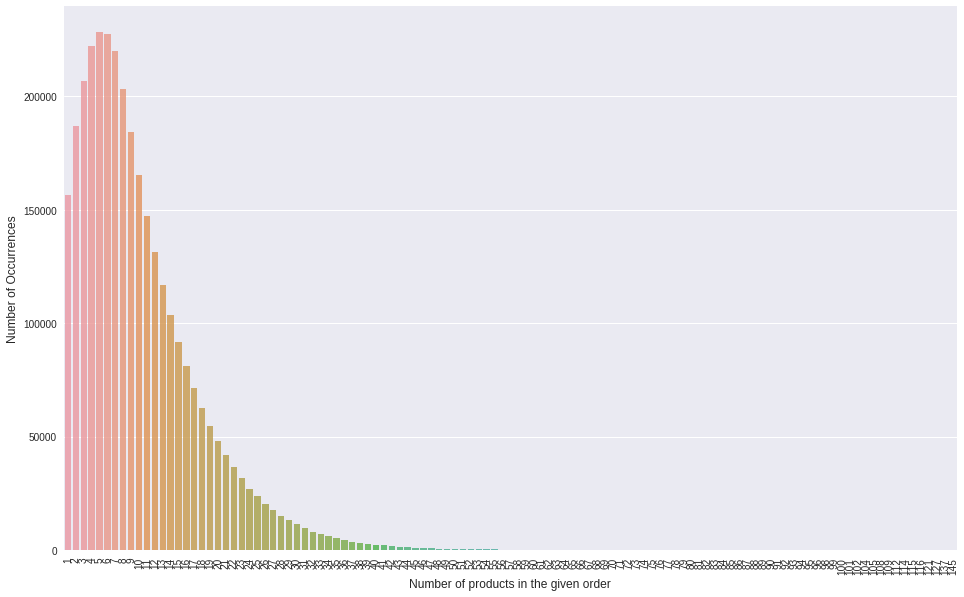

In [11]:
grouped_df = order_prod_prior.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(16,10))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

So the most common order size is 5 or 6, but there are many orders which are much larger.
In fact, 20 items per order is not unusual.

On the other hand, almost all orders have at most 56 items.

In [16]:
cnt_srs[cnt_srs.index > 56].sum()

1377

### Departments

Let us check the distribution of prior orders per department.

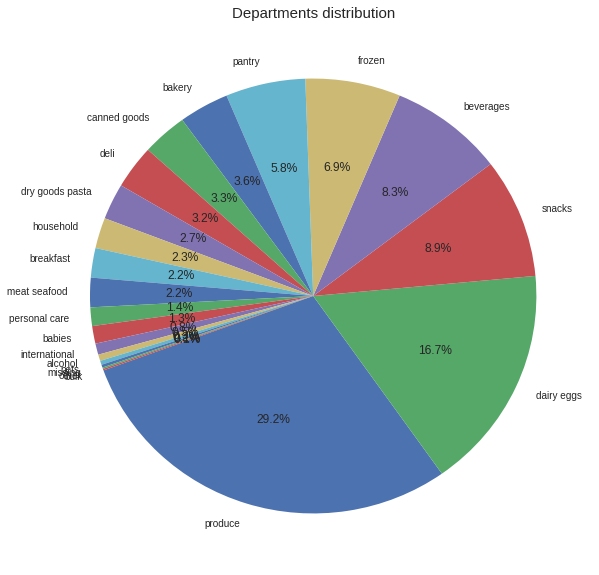

In [20]:
plt.figure(figsize=(10,10))
temp_series = order_prod_prior['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()

### Reorder relation to day of week

Does the reorder variable depend on the day of the week? We check below.

In [4]:
data = order_prod_prior.merge(orders, how='left', on='order_id')
data.head()    

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


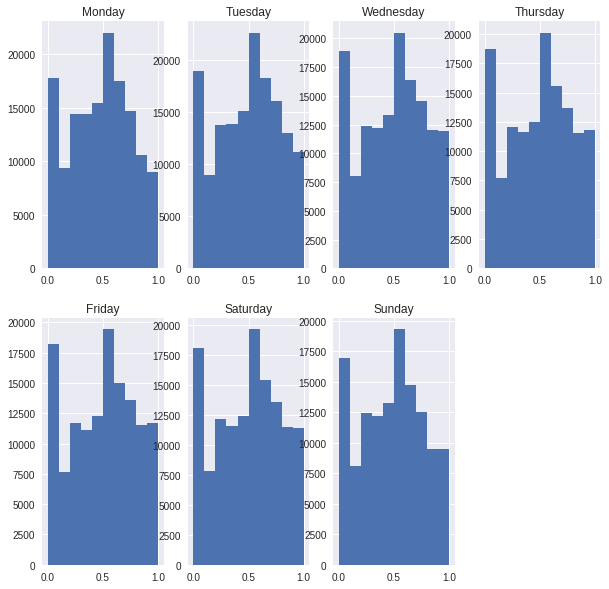

In [7]:
fig = plt.figure(figsize=(10, 10))
days = ['Monday', "Tuesday", 'Wednesday', "Thursday", "Friday", "Saturday", "Sunday"]
for i in range(7):
    ax = fig.add_subplot(2, 4, i+1)
    order_group = data[data.order_dow == i].groupby('user_id')
    info = order_group.reordered.sum() / order_group.reordered.size()
    ax.hist(info.values, range=(0, 1))
    ax.set_title(days[i])
plt.show()

At least on Friday and Saturday more people tend to reorder.

We also check if some users prefer some days for orders of certain products.

In [5]:
order_group = data.groupby(['user_id', 'product_id', 'order_dow'])
info = pd.DataFrame({'upo_per_day' : order_group.size()})
info = info.reset_index()

order_group = data.groupby(['user_id', 'product_id'])
info2 = pd.DataFrame({'upo_total' : order_group.size(), 'distinct_days' : order_group.order_dow.nunique()})
info2 = info2.reset_index()

info = info.merge(info2, how='left', on=['user_id', 'product_id'])
info['prob_order_per_day'] = info.upo_per_day / info.upo_total - 1/info['distinct_days']
info.head()

,user_id,product_id,order_dow,upo_per_day,distinct_days,upo_total,prob_order_per_day
0,1,196,1,3,4,10,0.050000
1,1,196,2,2,4,10,-0.050000
2,1,196,3,2,4,10,-0.050000
3,1,196,4,3,4,10,0.050000
4,1,10258,1,3,4,9,0.083333


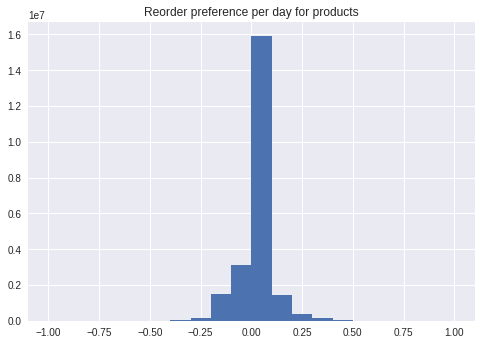

In [9]:
plt.hist(info.prob_order_per_day, range=(-1,1), bins=20)
plt.title('Reorder preference per day for products')
plt.show()

So there are a few users that order products on certain days, but most have no preference.

### Order gap for products

We explore the relation between the number of orders between reorders and the reorder chance.

In [3]:
data = order_prod_prior.merge(orders, how='left', on='order_id')
data.sort_values(by=['user_id', 'product_id', 'order_number'], inplace=True)
data.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
24076664,2539329,196,1,0,1,prior,1,2,8,NaN
22742744,2398795,196,1,1,1,prior,2,3,7,15.0
4488095,473747,196,1,1,1,prior,3,3,12,21.0
21376074,2254736,196,1,1,1,prior,4,4,7,29.0
4089398,431534,196,1,1,1,prior,5,4,15,28.0


In [13]:
info = data[['user_id', 'product_id', 'order_number', 'reordered']].copy()
info['prev_order'] = info.order_number.shift(1)
info['order_gap'] = np.maximum(0, (info.order_number - info.prev_order).values)
info = info[info.reordered > 0]
info2 = pd.DataFrame({'order_mean' : info.groupby(['user_id', 'product_id']).order_gap.mean()})
info2.head()

order_mean
user_id product_id            
1       196                1.0
        10258              1.0
        12427              1.0
        13032              4.0
        13176              3.0

In [14]:
info = info.join(info2, how='left', on=['user_id', 'product_id'])
info['order_gap_var'] = info.order_gap - info.order_mean
info.head()

,user_id,product_id,order_number,reordered,prev_order,order_gap,order_mean,order_gap_var
22742744,1,196,2,1,1.0,1.0,1.0,0.0
4488095,1,196,3,1,2.0,1.0,1.0,0.0
21376074,1,196,4,1,3.0,1.0,1.0,0.0
4089398,1,196,5,1,4.0,1.0,1.0,0.0
31927070,1,196,6,1,5.0,1.0,1.0,0.0


Now plot the variance around the mean.

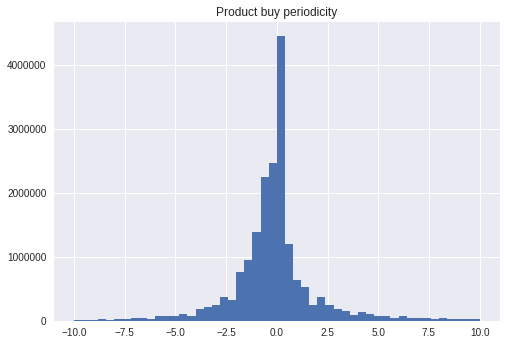

In [19]:
plt.hist(info.order_gap_var, range=(-10,10), bins=50)
plt.title('Product buy periodicity')
plt.show()

So many products are bought at regular intervals.

### Time gap between reorders

We compute the number of days elapsed between consecutive orders of the same product.

In [4]:
data = orders.copy()
data.sort_values(by=['user_id', 'order_number'], inplace=True)
data.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


The first step is to compute the number of days elapsed since the first order.

In [8]:
data.days_since_prior_order.fillna(0, inplace=True)
data['days_since_first_order'] = data.groupby('user_id').days_since_prior_order.cumsum(axis=0).reset_index(drop=True)
data.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_first_order
0,2539329,1,prior,1,2,8,0.0,0.0
1,2398795,1,prior,2,3,7,15.0,15.0
2,473747,1,prior,3,3,12,21.0,36.0
3,2254736,1,prior,4,4,7,29.0,65.0
4,431534,1,prior,5,4,15,28.0,93.0


We now join with the order information and process per product.

In [5]:
data = data.drop(['order_dow', 'order_hour_of_day', 'days_since_prior_order'], axis = 1)
data = data[data.eval_set == 'prior']
data = data.drop(['eval_set'], axis = 1)
data = order_prod_prior.merge(data, how='left', on='order_id')
data.sort_values(by=['user_id', 'product_id', 'order_number'], inplace=True)
data['days_since_op'] = data.days_since_first_order - data.days_since_first_order.shift(1)
data = data[data.reordered > 0]

We check the distribution of reorders as a function of days since previous order.

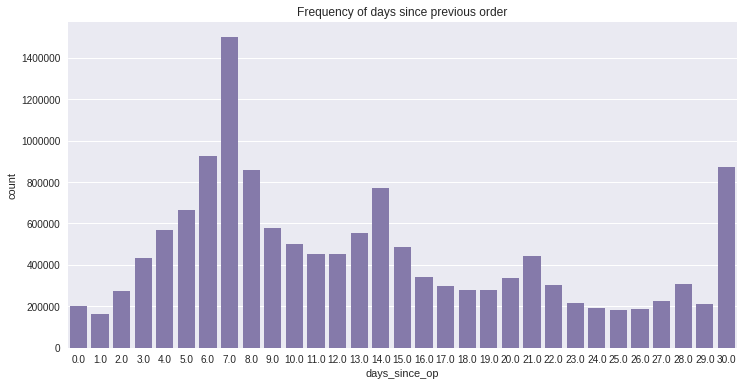

In [14]:
plt.figure(figsize=(12, 6))
sns.countplot(x="days_since_op", data=data[data.days_since_op <= 30], color=color[3])
plt.title('Frequency of days since previous order')
plt.show()

There are 3 peaks, at 7, 14 and 21 days. Of course, this might be because some people always order on Sundays, and always buy the the same products.

### Organic products

We check if organic products are more preferred.

In [3]:
info = products.copy()
info['organic'] = info.product_name.str.contains('organic', case=False)
info[info.organic].head()

,product_id,product_name,aisle_id,department_id,organic
22,23,Organic Turkey Burgers,49,12,True
32,33,Organic Spaghetti Style Pasta,131,9,True
40,41,Organic Sourdough Einkorn Crackers Rosemary,78,19,True
42,43,Organic Clementines,123,4,True
46,47,Onion Flavor Organic Roasted Seaweed Snack,66,6,True


In [4]:
data = order_prod_prior.merge(info, how='left', on='product_id')
data.groupby('organic').agg({'reordered' : ['sum', 'size']}) 

reordered          
              sum      size
organic                    
False    12618112  22183774
True      6508424  10250715

### Products that were bought only once

We check how many products were bought only one time.

In [5]:
data = order_prod_prior.merge(orders, how='left', on='order_id')
info = pd.DataFrame({'up_norders' : data.groupby(['user_id', 'product_id']).size()})
info = info.reset_index()

In [23]:
print('Number of (user, product) pairs:', info.shape[0])
print('Number of (user, product) appearing only once:', (info.up_norders == 1).sum())
print('Number of total prior (user, product) orders:', order_prod_prior.shape[0])

Number of (user, product) pairs: 13307953
Number of (user, product) appearing only once: 7982695
Number of total prior (user, product) orders: 32434489


Let us see how these pairs are split in the train and test set.

In [24]:
info2 = pd.DataFrame({'u_single_order': info[info.up_norders == 1].groupby('user_id').size()})
info2 = info2.reset_index()
info2 = orders[orders.eval_set.isin(['train', 'test'])].merge(info2, how='left', on='user_id')

In [25]:
print('Number in the train set:', info2[info2.eval_set == 'train'].u_single_order.sum())
print('Number in the test set:', info2[info2.eval_set == 'test'].u_single_order.sum())

Number in the train set: 5083521.0
Number in the test set: 2899174.0


So there's quite a lot of them in each. It makes sense to try to build some special features for these pairs,
as the usual approach (mining the (user, product) history), doesn't work.

Let us call these products *special*. Let us see how many special products are reordered in the train set.

In [26]:
info2 = orders[orders.eval_set == 'train'].merge(info, how='left', on='user_id')
info2 = info2.drop('eval_set', axis=1)
# add the reordered column
order_group  = order_prod_train[['order_id', 'product_id', 'reordered']]
info2 = info2.merge(order_group, how='left', on=['order_id', 'product_id'])
assert (info2.loc[~info2.reordered.isnull(), 'reordered'] == 1).all()
info2.reordered.fillna(0, inplace=True)
print('Number of possibilities:', info2.shape[0])
print('Number of reordered special products:', info2[info2.up_norders == 1].reordered.sum())
print('Number of not reordered special products:', (info2.up_norders == 1).sum() - info2[info2.up_norders == 1].reordered.sum())
print('Number of reordered products:', info2.reordered.sum())

Number of possibilities: 8474661
Number of reordered special products: 239222.0
Number of not reordered special products: 4844299.0
Number of reordered products: 828824.0


### Frequently bought products

Let us find the top most ordered products.

In [9]:
data = order_prod_prior.merge(products, how='left', on='product_id')
data = data.merge(orders[['order_id', 'user_id']], how='left', on='order_id')

In [10]:
cnt_srs = data['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


So the most ordered products are organic fruits and vegetables.